Can we predict the ratio of a game?

Bins for ratings; -3, -2,-1, 0, 1, 2, 3, 4, 5



In [616]:
import pandas as pd # for working with data
import numpy as np # for working with data
import seaborn as sns # for making visualizations
from matplotlib import pyplot as plt # for making visualizations
import sklearn as sk
import datetime as dt
import math
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [617]:
steam_df: pd.DataFrame = pd.read_csv('games_may2024_cleaned.csv')

In [618]:
columns_to_keep = [
    'required_age',
    'price',
    'dlc_count',
    'windows',
    'mac',
    'linux',
    'achievements',
    'supported_languages',
    'estimated_owners',
    'average_playtime_forever',
    'average_playtime_2weeks',
    'median_playtime_forever',
    'median_playtime_2weeks',
    'peak_ccu',
    'tags',
    'positive',
    'negative'
]

steam_df = steam_df.filter(columns_to_keep)

In [619]:
steam_df.dtypes

required_age                  int64
price                       float64
dlc_count                     int64
windows                        bool
mac                            bool
linux                          bool
metacritic_score              int64
achievements                  int64
supported_languages          object
estimated_owners             object
average_playtime_forever      int64
average_playtime_2weeks       int64
median_playtime_forever       int64
median_playtime_2weeks        int64
peak_ccu                      int64
tags                         object
positive                      int64
negative                      int64
dtype: object

In [620]:
steam_df['total_review_count'] = steam_df['positive'] + steam_df['negative']
steam_df = steam_df[steam_df['total_review_count'] >= 10]

steam_df['positive_review_percentage'] = (steam_df['positive'] / steam_df['total_review_count']) * 100.0
steam_df = steam_df[steam_df['positive_review_percentage'].isna() == False]

In [621]:
# Calculate Rating based on Steam rating standards
def calculate_steam_rating(num_reviews: int, prp: float) -> int:
    match num_reviews:
        case num_reviews if num_reviews <= 49:
            match prp:
                case prp if 0 <= prp <= 19.0:
                    return 6
                case prp if  29.0 <= prp <= 39.0:
                    return 5
                case prp if 40.0 <= prp <= 69.0:
                    return 4
                case prp if 70.0 <= prp <= 79.0:
                    return 3
                case prp if 80.0 <= prp <= 100.0:
                    return 2
        case num_reviews if 50 >= num_reviews <= 499:
            match prp:
                case prp if 0 <= prp <= 19.0:
                    return 7
                case prp if  29.0 <= prp <= 39.0:
                    return 5
                case prp if 40.0 <= prp <= 69.0:
                    return 4
                case prp if 70.0 <= prp <= 79.0:
                    return 3
                case prp if 80.0 <= prp <= 100.0:
                    return 1
        case num_reviews if 500 <= num_reviews <= 100_000_000:
            match prp:
                case prp if 0.0 <= prp <= 19.0:
                    return 8
                case prp if  29.0 <= prp <= 39.0:
                    return 5
                case prp if 40.0 <= prp <= 69.0:
                    return 4
                case prp if 70.0 <= prp <= 79.0:
                    return 3
                case prp if 80.0 <= prp <= 94.0:
                    return 1
                case prp if 95.0 <= prp <= 100.0:
                    return 0
                


In [622]:
steam_df['steam_review'] = steam_df.apply(lambda x: calculate_steam_rating(x['total_review_count'], x['positive_review_percentage']), axis=1)

price_bin_edges = [0, 10, 15, 25, 30, 40, 60, np.inf]

steam_df['price_binned'] = pd.cut(steam_df['price'], bins=price_bin_edges, labels=False, include_lowest=True)



In [623]:

def parse_tags(tag_str):
    if pd.isna(tag_str):
        return {}
    try:
        return ast.literal_eval(tag_str)
    except (ValueError, SyntaxError):
        return {}


steam_df['tags'] = steam_df['tags'].apply(parse_tags)

tags_df = steam_df['tags'].apply(lambda tags: pd.Series({tag: 1 for tag in tags})).fillna(0)


steam_df = steam_df.drop(['tags'], axis=1)


tag_totals = tags_df.sum().sort_values(ascending=False)
N = 50
top_tags = tag_totals.head(N).index


tags_df = tags_df[top_tags]


steam_df = pd.concat([steam_df, tags_df], axis=1)

steam_df

,required_age,price,dlc_count,windows,mac,linux,metacritic_score,achievements,supported_languages,estimated_owners,...,Controller,Comedy,Co-op,Stylized,Psychological Horror,VR,FPS,Top-Down,Mystery,Point & Click
0,0,0.00,1,True,False,True,0,1,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...",100000000 - 200000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.00,0,True,False,False,0,37,"['English', 'Korean', 'Simplified Chinese', 'F...",50000000 - 100000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0.00,2,True,True,True,90,0,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...",200000000 - 500000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17,0.00,1,True,False,False,96,77,"['English', 'French', 'Italian', 'German', 'Sp...",50000000 - 100000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,19.99,9,True,False,False,0,0,"['English', 'French', 'Italian', 'German', 'Sp...",20000000 - 50000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83603,0,8.24,0,True,True,True,0,0,['English'],0 - 20000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83629,0,7.99,0,True,False,False,0,8,"['English', 'Japanese']",0 - 20000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83635,0,1.19,0,True,False,False,0,0,['English'],0 - 20000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83639,0,4.99,0,True,False,False,0,0,['English'],0 - 20000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [624]:

from collections import Counter

# Step 1: Parse the supported_languages column correctly
def parse_languages(lang_str):
    if pd.isna(lang_str):
        return []
    try:
        return ast.literal_eval(lang_str)
    except (ValueError, SyntaxError):
        return []

steam_df['supported_languages'] = steam_df['supported_languages'].apply(parse_languages)

# Step 2: Extract the most common languages
all_languages = [lang for langs in steam_df['supported_languages'] for lang in langs]
language_counts = Counter(all_languages)
most_common_languages = [lang for lang, count in language_counts.most_common(10)]

steam_df['supported_languages'] = steam_df['supported_languages'].apply(
    lambda langs: [lang for lang in langs if lang in most_common_languages]
)

# Step 3: Apply MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
languages_dummies = pd.DataFrame(
    mlb.fit_transform(steam_df['supported_languages']),
    columns=mlb.classes_,
    index=steam_df.index
)

# Concatenate the dummy variables to the original DataFrame
steam_df = pd.concat([steam_df, languages_dummies], axis=1)

# Drop the original 'supported_languages' column if it's no longer needed
steam_df.drop(columns=['supported_languages'], inplace=True)

# Display the result
steam_df.head()

,required_age,price,dlc_count,windows,mac,linux,metacritic_score,achievements,estimated_owners,average_playtime_forever,...,English,French,German,Italian,Japanese,Korean,Portuguese - Brazil,Russian,Simplified Chinese,Spanish - Spain
0,0,0.00,1,True,False,True,0,1,100000000 - 200000000,29018,...,1,1,1,1,1,1,1,1,1,1
1,0,0.00,0,True,False,False,0,37,50000000 - 100000000,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0.00,2,True,True,True,90,0,200000000 - 500000000,35557,...,1,1,1,1,1,1,1,1,1,1
3,17,0.00,1,True,False,False,96,77,50000000 - 100000000,12898,...,1,1,1,1,1,1,1,1,1,1
4,17,19.99,9,True,False,False,0,0,20000000 - 50000000,16213,...,1,1,1,1,1,1,1,1,1,1


In [625]:
columns_to_bin = [
    'required_age',
    'price',
    'dlc_count',
    'windows',
    'mac',
    'linux',
    'achievements',
    'estimated_owners',
    'average_playtime_forever',
    'average_playtime_2weeks',
    'median_playtime_forever',
    'median_playtime_2weeks',
]

steam_df = steam_df.drop(['total_review_count', 'positive_review_percentage', 'negative', 'positive', 'peak_ccu'], axis=1)

# Step 1: Convert columns to numeric where possible
for col in columns_to_bin:
    if col in steam_df.columns:
        try:
            steam_df[col] = pd.to_numeric(steam_df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col} to numeric: {e}")

# Step 2: Filter out non-numeric columns
numeric_columns_to_bin = [col for col in columns_to_bin if steam_df[col].dtype in ['int64', 'float64']]

# Step 3: Bin the numeric columns
num_bins = 10
for col in numeric_columns_to_bin:
    if col in steam_df.columns:
        steam_df[f'{col}_binned'] = pd.qcut(steam_df[col], q=num_bins, duplicates='drop')

# Step 4: Drop original columns
steam_df.drop(columns=numeric_columns_to_bin, inplace=True)

# Step 5: Apply one-hot encoding to binned columns
binned_columns = [f'{col}_binned' for col in numeric_columns_to_bin]
steam_df = pd.get_dummies(steam_df, columns=binned_columns)

# Check the resulting DataFrame
steam_df.head()

KeyError: "['score_rank', 'user_score'] not found in axis"

<Axes: xlabel='steam_review', ylabel='count'>

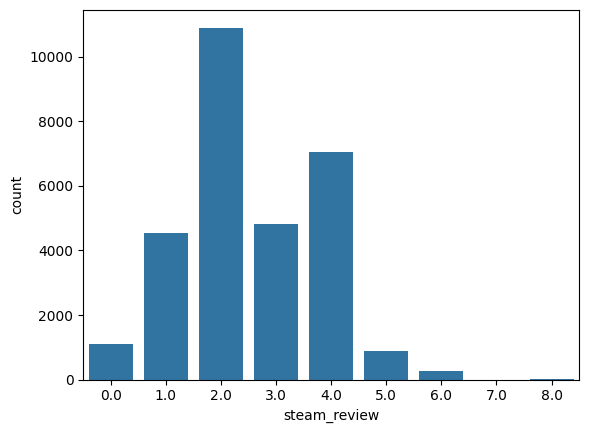

In [596]:
#review_order = ['overwhelmingly_positive', 'very_positive', 'positive', 'mostly_positive', 'mixed', 'mostly_negative' 'negative', 'very_negative', 'overwhelmingly_negative']
sns.countplot(data=steam_df, x='steam_review')


In [597]:
# Convert steam_reviews to ints
cols = list(steam_df.columns)
cols.remove('steam_review')

steam_df = pd.get_dummies(steam_df,  columns=cols)



In [598]:
X = steam_df.drop(columns = ['steam_review'])
y = steam_df['steam_review']
y.fillna(0, inplace=True)


In [599]:
from sklearn.model_selection import train_test_split

In [600]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [601]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36199, 174), (12067, 174), (36199,), (12067,))

In [602]:
from sklearn import tree

In [603]:
model = tree.DecisionTreeClassifier()

In [612]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.34979696693461504

In [605]:
fi = model.feature_importances_ #feature importance array
fi = pd.Series(data = fi, index = X.columns) #convert to Pandas series for plotting
fi.sort_values(ascending=False, inplace=True) #sort descending

C:\Users\noahe\AppData\Local\Temp\ipykernel_14188\527160214.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(x=fi, y=fi.index, palette=sns.color_palette("BuGn_r", n_colors=len(fi)))
C:\Users\noahe\AppData\Local\Temp\ipykernel_14188\527160214.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


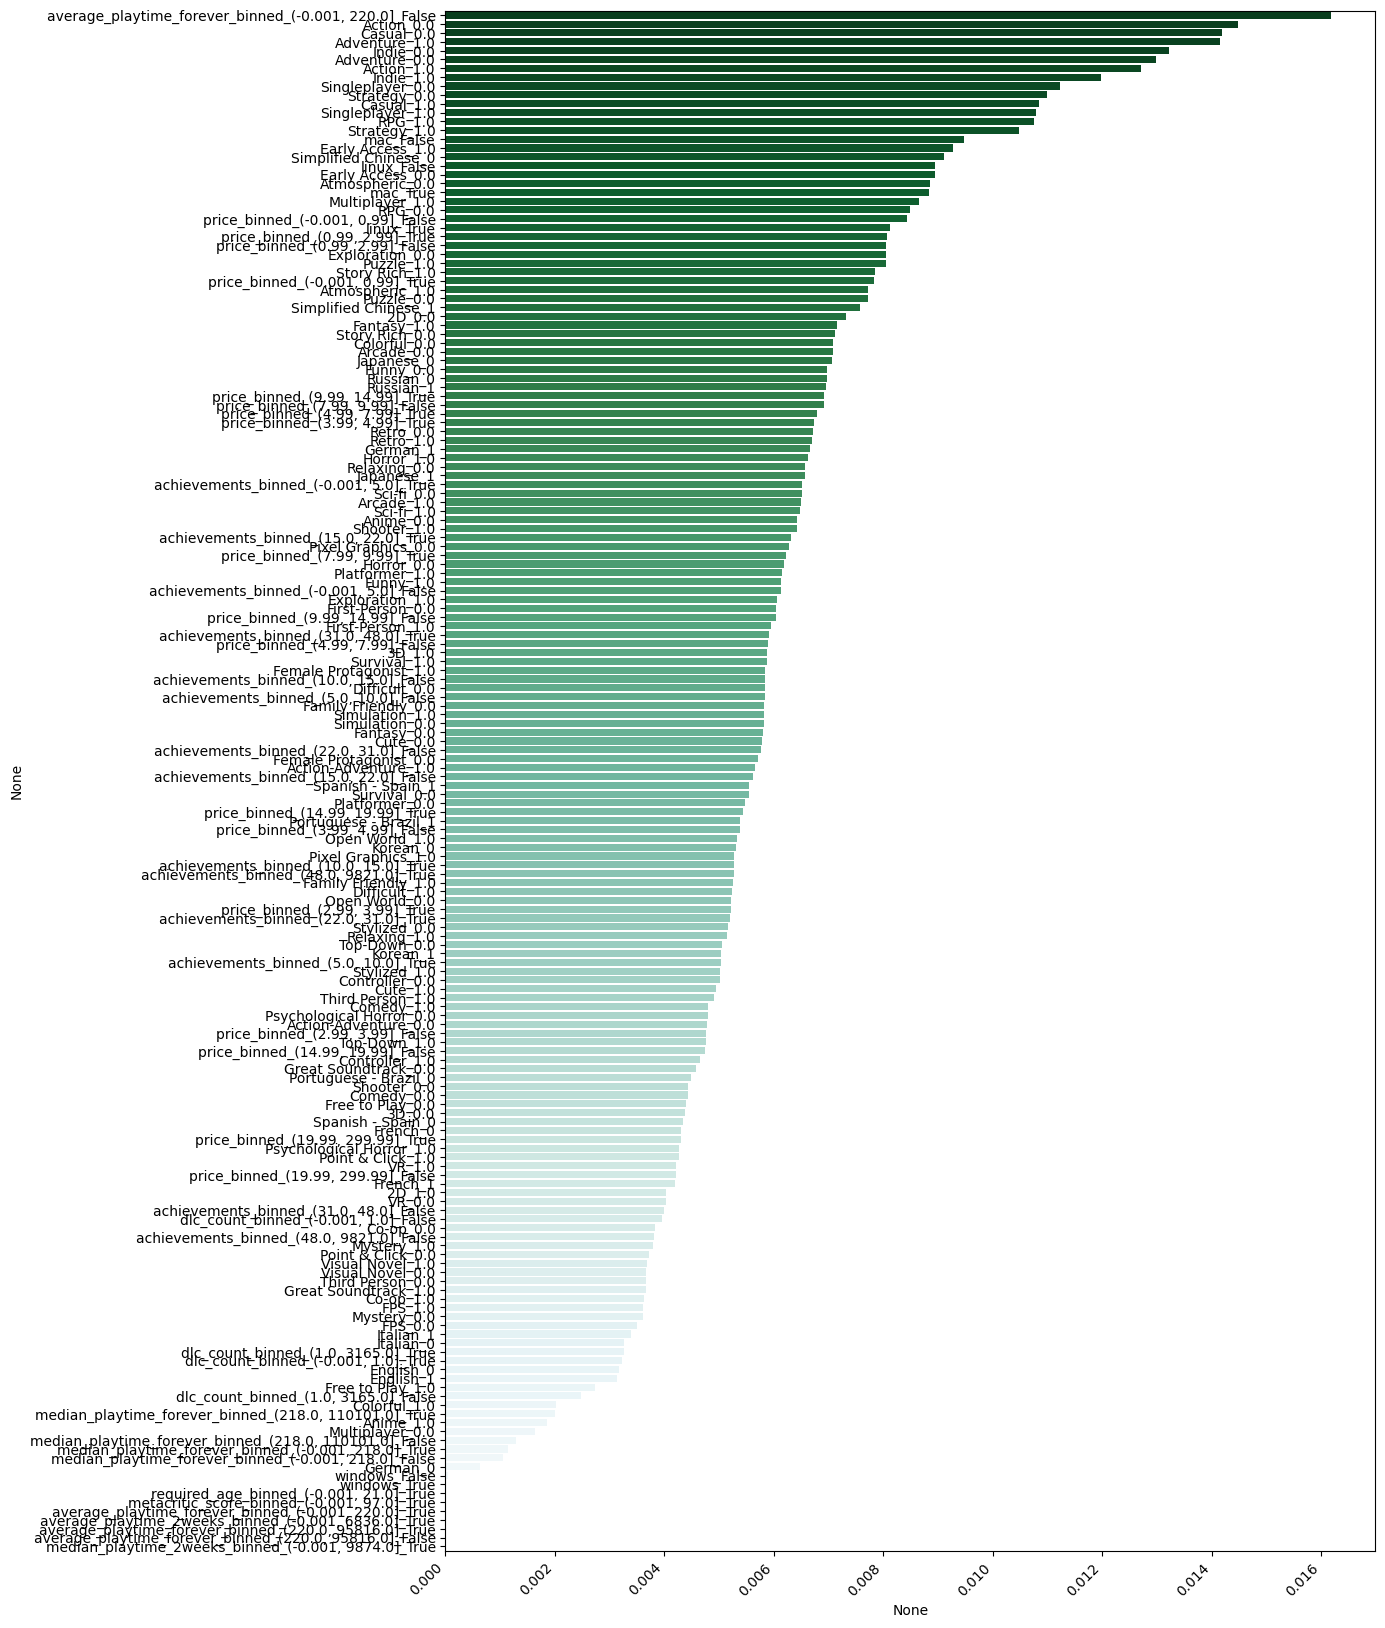

In [606]:
#create bar plot
plt.figure(figsize=(12, 20))
chart = sns.barplot(x=fi, y=fi.index, palette=sns.color_palette("BuGn_r", n_colors=len(fi)))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [607]:
from sklearn import metrics

In [608]:
predicted = model.predict(X_test)

In [615]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.49      0.47      0.48      5022
         1.0       0.26      0.27      0.26      1128
         2.0       0.38      0.38      0.38      2745
         3.0       0.12      0.13      0.13      1208
         4.0       0.19      0.21      0.20      1685
         5.0       0.06      0.06      0.06       212
         6.0       0.03      0.03      0.03        64
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         2

    accuracy                           0.35     12067
   macro avg       0.17      0.17      0.17     12067
weighted avg       0.35      0.35      0.35     12067



c:\Users\noahe\itsc3162\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noahe\itsc3162\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noahe\itsc3162\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [610]:
from sklearn.metrics import classification_report, confusion_matrix

In [611]:
confusion_matrix(y_test, predicted)

array([[2373,  479,  940,  443,  672,   83,   29,    0,    3],
       [ 440,  303,  100,  147,  125,   11,    2,    0,    0],
       [ 913,  123, 1034,  249,  379,   34,   13,    0,    0],
       [ 398,  154,  255,  155,  215,   23,    8,    0,    0],
       [ 633,  110,  331,  209,  346,   38,   17,    0,    1],
       [  62,   10,   44,   27,   50,   13,    6,    0,    0],
       [  30,    1,   10,    9,    8,    4,    2,    0,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0],
       [   0,    0,    1,    1,    0,    0,    0,    0,    0]])